<a href="https://colab.research.google.com/github/taemmini/2023_Fall_HUFS_ML_Project_7/blob/main/CAPTCHA_Project_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>NETIS 공유기에서 사용되는 CAPTCHA 이미지 해석 시도</h3>

> 실제 사용되는 CAPTCHA 이미지를 모방하여 만든 이미지를 사용해 학습과 예측을 시도한 케이스입니다.

> Overfitting을 방지하기 위해 가우시안 블러처리한 이미지를 사용해 학습시키고, 예측을 시도한 케이스입니다.

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from keras import layers

import cv2
from sklearn.model_selection import train_test_split

In [3]:
import random

<h3>이미지 경로를 불러오고, 경로로부터 레이블을 분리</h3>

In [4]:
def load_image_with_label(folder_path : str, extension : str):
    images = glob(r".\resource\%s\*.%s"%(folder_path, extension))
    labels = [img.split(os.path.sep)[3].split('.'+extension)[0].split('_')[0] for img in images]
    return (images, labels)

In [5]:
images, labels = load_image_with_label('NETIS_Gaussian','png')
print(len(labels), labels[0])

29996 000wx


<h3>문자를 하나의 int로 나타낸 클래스로 변환하거나, 그 역을 수행하는 기능을 정의</h3>

In [6]:
unique_char = sorted(list(set(''.join(labels))))
print(unique_char)
print(len(unique_char))

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(unique_char), num_oov_indices = 0, mask_token = None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), num_oov_indices = 0, mask_token = None, invert = True
)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
36



C:\Users\yongh\anaconda3\Lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=777)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

26996 3000
26996 3000


<h3>이미지 경로-레이블 매칭 확인</h3>

+ 이미지가 흐릿하게 보이는 가우시안 블러처리가 되었다는 점을 확인할 수 있습니다

vn5e4


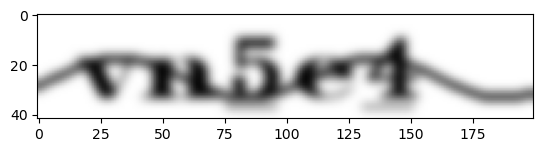

In [8]:
# 제대로 매칭되어 있는지 확인
sample = cv2.imread(x_train[0])
print(y_train[0])
plt.imshow(sample)

<h3>학습이 용이하도록 이미지를 전처리</h3>

In [9]:
img_width = 200
img_height = 42

def encode_image(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.transpose(img, perm=[1,0,2])

  label = char_to_num(tf.strings.unicode_split(label, input_encoding = 'UTF-8'))

  return {'image':img, 'label':label}

In [11]:
# 모델에 넣을 데이터셋 구성(배치 학습이 아니기 때문에 정해진 배치사이즈마다 일정한 양의 데이터 묶음을 넣어 학습 진행)

batch_size = 64
# tf가 제공하는 Dataset을 사용하는게 학습이 더 빨라서 일반적으로 사용하는 것 같습니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(test_dataset)


<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 42, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 42, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


<h3>모델 정의</h3>

In [12]:
# CTC손실함수 정의 : 정형화된 구현 방법이 존재하여 그대로 가져왔습니다.

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # Convolution, Maxpooling을 각각 두번하여 차원을 축소함

    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNN을 두 차례 사용
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # 출력층 구성
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # CTC 손실함수 적용
    output = CTCLayer(name='ctc_loss')(labels, x)

    # 모델 구성
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # 케라스에서 제공하는 최적화
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model

<h3> 실제 학습과 모델 구축 </h3>

In [13]:
#학습

model = build_model()

epochs = 30
stopping_patience = 30
#restore_best_weights : 조기종료 후 지금까지 최적값을 냈던 가중치를 다시 선택함
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = epochs,
    callbacks=[early_stopping],
)



Epoch 1/30
422/422 [==============================] - 48s 105ms/step - loss: 20.3346 - val_loss: 19.1562
Epoch 2/30
422/422 [==============================] - 43s 103ms/step - loss: 18.8030 - val_loss: 18.3468
Epoch 3/30
422/422 [==============================] - 43s 101ms/step - loss: 17.8843 - val_loss: 17.1552
Epoch 4/30
422/422 [==============================] - 43s 101ms/step - loss: 16.0363 - val_loss: 14.4084
Epoch 5/30
422/422 [==============================] - 42s 99ms/step - loss: 13.0228 - val_loss: 10.8607
Epoch 6/30
422/422 [==============================] - 42s 99ms/step - loss: 10.0164 - val_loss: 7.8566
Epoch 7/30
422/422 [==============================] - 42s 101ms/step - loss: 7.5831 - val_loss: 5.9670
Epoch 8/30
422/422 [==============================] - 42s 100ms/step - loss: 5.8850 - val_loss: 4.4410
Epoch 9/30
422/422 [==============================] - 43s 102ms/step - loss: 4.6095 - val_loss: 3.2929
Epoch 10/30
422/422 [==============================] - 43s 102

In [34]:
epochs = 10
stopping_patience = 10
#restore_best_weights : 조기종료 후 지금까지 최적값을 냈던 가중치를 다시 선택함
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = epochs,
    callbacks=[early_stopping],
)

Epoch 1/10
422/422 [==============================] - 44s 103ms/step - loss: 0.1765 - val_loss: 0.0688
Epoch 2/10
422/422 [==============================] - 43s 102ms/step - loss: 0.0887 - val_loss: 0.0591
Epoch 3/10
422/422 [==============================] - 44s 105ms/step - loss: 0.0765 - val_loss: 0.0644
Epoch 4/10
422/422 [==============================] - 43s 103ms/step - loss: 0.0718 - val_loss: 0.0589
Epoch 5/10
422/422 [==============================] - 44s 105ms/step - loss: 0.1409 - val_loss: 0.1433
Epoch 6/10
422/422 [==============================] - 44s 104ms/step - loss: 0.1155 - val_loss: 0.0591
Epoch 7/10
422/422 [==============================] - 44s 103ms/step - loss: 0.0677 - val_loss: 0.0625
Epoch 8/10
422/422 [==============================] - 43s 101ms/step - loss: 0.0865 - val_loss: 0.0549
Epoch 9/10
422/422 [==============================] - 44s 105ms/step - loss: 0.1119 - val_loss: 0.0800
Epoch 10/10
422/422 [==============================] - 44s 104ms/step - l

In [14]:
label_length = [len(label) for label in labels]
max_length = max(label_length)

In [15]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    # encode된 글자를 복원하여 리스트에 저장
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

In [35]:
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

In [17]:
test_images, test_labels = load_image_with_label("NETIS_Labled_Gaussian",'png')

In [18]:
testDataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
testDataset = testDataset.map(encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
testDataset = testDataset.batch(len(test_labels))

<h3>실제 사용되는 CAPTCHA 이미지로 예측 시도</h3>

+ 위는 Blur_level = 1, 중간은 Blur_level = 2, 아래는 Blur_level = 3인 이미지로 예측을 시도한 경우입니다.

+ 너무 미미한 블러처리나, 과도한 블러처리 모두 정확도 개선에 도움이 되지 않는다는 점을 알 수 있었습니다.

+ 여러 가중치에 대해 테스트를 해보았으며, 본 노트북은 그중 가장 결과가 좋았던 경우입니다.

1/1 [==============================] - 1s 766ms/step


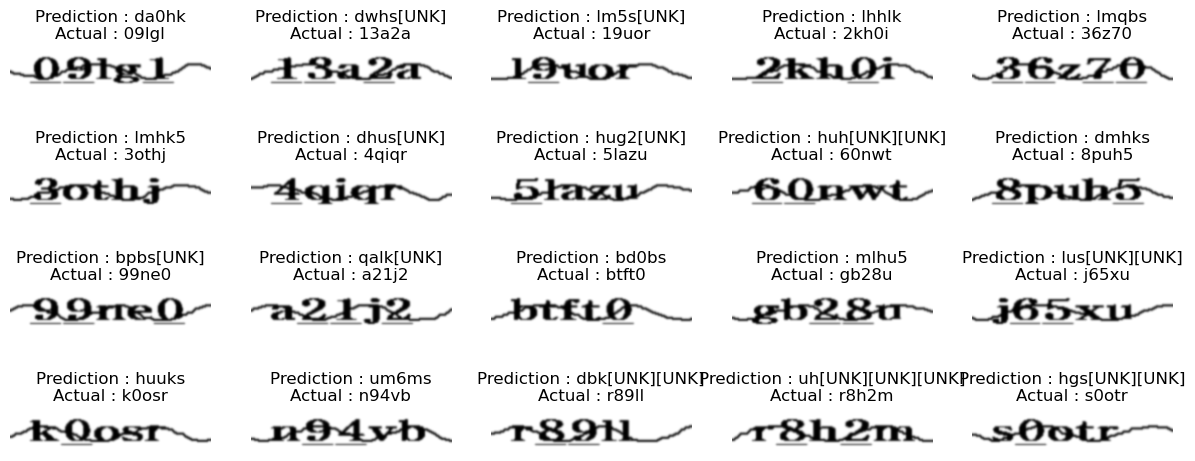

In [36]:
for batch in testDataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(4, 5, figsize=(15, 6))

    for img, text, label, ax in zip(batch_images, pred_texts, batch_labels, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T # 이미지처리 과정에서 Transpose했던 것을 다시 복구함
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        text = "Prediction : %s\nActual : %s"%(text, label)
        
        ax.imshow(img, cmap="gray")
        ax.set_title(text)
        ax.set_axis_off()

In [21]:
test_images2, test_labels2 = load_image_with_label("NETIS_Labled_Gaussian_2x",'png')
testDataset2 = tf.data.Dataset.from_tensor_slices((test_images2, test_labels2))
testDataset2 = testDataset2.map(encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
testDataset2 = testDataset2.batch(len(test_labels2))

1/1 [==============================] - 0s 64ms/step


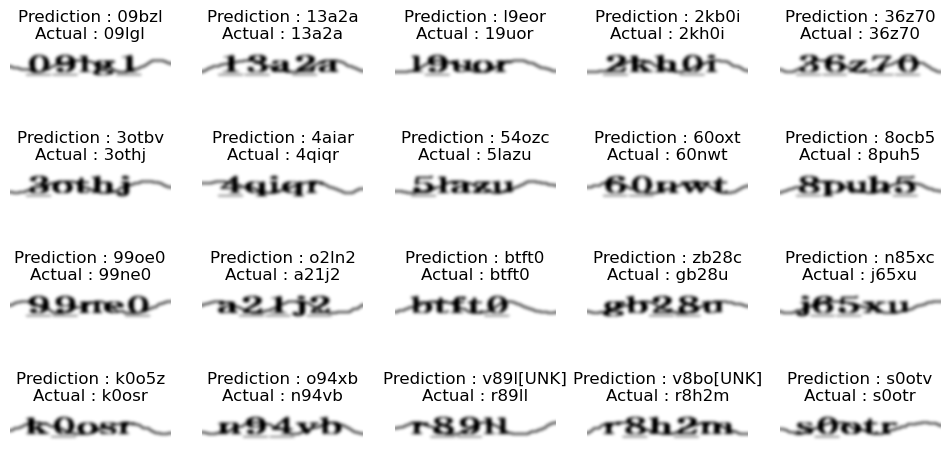

In [37]:
for batch in testDataset2.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(4, 5, figsize=(12, 6))

    for img, text, label, ax in zip(batch_images, pred_texts, batch_labels, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T # 이미지처리 과정에서 Transpose했던 것을 다시 복구함
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        text = "Prediction : %s\nActual : %s"%(text, label)
        
        ax.imshow(img, cmap="gray")
        ax.set_title(text)
        ax.set_axis_off()

In [23]:
test_images3, test_labels3 = load_image_with_label("NETIS_Labled_Gaussian_3x",'png')
testDataset3 = tf.data.Dataset.from_tensor_slices((test_images3, test_labels3))
testDataset3 = testDataset3.map(encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
testDataset3 = testDataset3.batch(len(test_labels2))

1/1 [==============================] - 0s 44ms/step


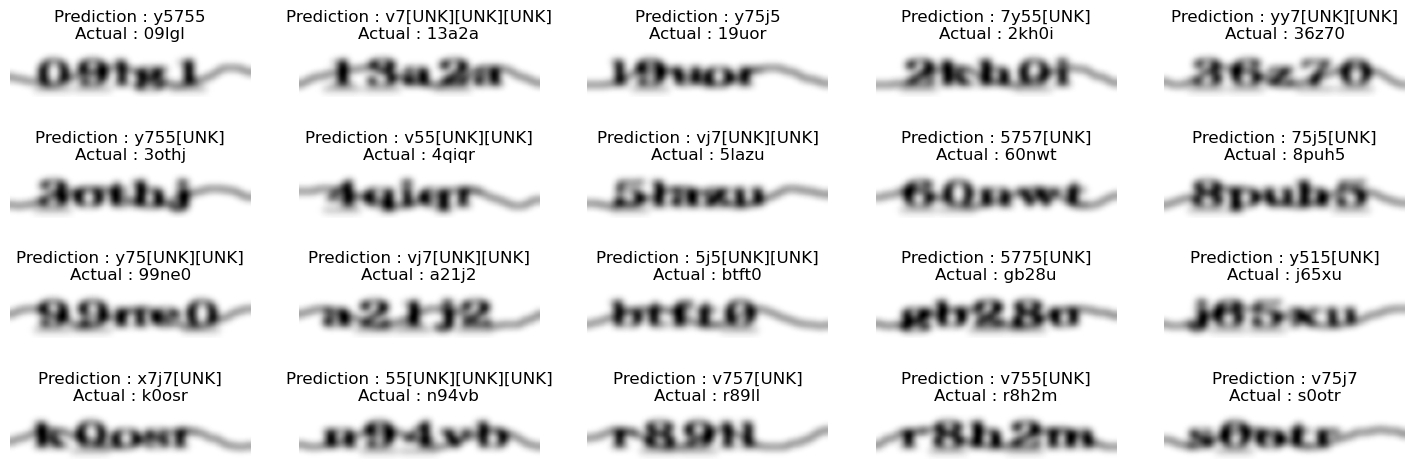

In [38]:
for batch in testDataset3.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(4, 5, figsize=(18, 6))

    for img, text, label, ax in zip(batch_images, pred_texts, batch_labels, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T # 이미지처리 과정에서 Transpose했던 것을 다시 복구함
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        text = "Prediction : %s\nActual : %s"%(text, label)
        
        ax.imshow(img, cmap="gray")
        ax.set_title(text)
        ax.set_axis_off()